# Notebook for cell classification based on trained squeezenet network

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler
import os
import copy
import time
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas
import glob
from tqdm.notebook import tqdm
import shutil

# Predictions on new images

### Load trained network

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
feature_extract = True
num_classes = 2

In [5]:
model_load = models.squeezenet1_0(pretrained=True)
set_parameter_requires_grad(model_load, feature_extract)
model_load.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
input_size = 224

MODEL_SAVE_PATH = 'trained_networks'
modelname = 'CD45_trained_model_squeezenet'

model_load.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, modelname), map_location=torch.device('cpu')))

# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_load = model_load.to(device)

In [6]:
def predict_cell_types(IMAGE_DIR,
                       model,
                       savename,
                       colname):
    
    # the validation transforms
    prod_transform = transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    classification_frame = pandas.DataFrame()
    i = 0

    flist = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.tif')))
        
    if not os.path.exists(os.path.join(IMAGE_DIR, 'positive')):
        os.mkdir(os.path.join(IMAGE_DIR, 'positive'))
    if not os.path.exists(os.path.join(IMAGE_DIR, 'negative')):
        os.mkdir(os.path.join(IMAGE_DIR, 'negative'))
        
    classes = ['negative', 'positive']

    for fname in tqdm(flist):

        fname_basename = os.path.basename(fname)
        label, _ = fname_basename.split('.')

        img = Image.open(fname)
        img_t = prod_transform(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)

        outputs = model(batch_t)
        percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        _, preds = torch.max(outputs, 1)

        preds = preds.cpu().detach().numpy()
        percentage = percentage.cpu().detach().numpy()

        classification_frame.loc[i, 'label'] = label
        classification_frame.loc[i, 'fname'] = fname
        classification_frame.loc[i, 'prob'] = percentage[preds[0]]
        classification_frame.loc[i, colname] = classes[preds[0]]
        classification_frame.loc[i, colname + '_value'] = preds[0]
        i += 1
        
        if preds[0] == 0:
            shutil.copyfile(fname, os.path.join(IMAGE_DIR, 'negative',fname_basename))
        elif preds[0] == 1:
            shutil.copyfile(fname, os.path.join(IMAGE_DIR, 'positive',fname_basename))
        
    DIRNAME = os.path.dirname(IMAGE_DIR)    
    classification_frame.to_csv(os.path.join(DIRNAME, savename), index = False)
    
    return True

### Classify on single cell images

In [9]:
PATH_CD45_data = 'Example_cell_classification_CD45'

pathlist = [PATH_CD45_data]

savename = 'Example_CD45_classification.csv'
colname = 'CD45_NN_prediction'

In [ ]:
for pathname in pathlist:
    
    predict_cell_types(pathname,
                   model_load,
                   savename,
                   colname)

### Check classification on some examples

In [11]:
# the validation transforms
prod_transform = transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

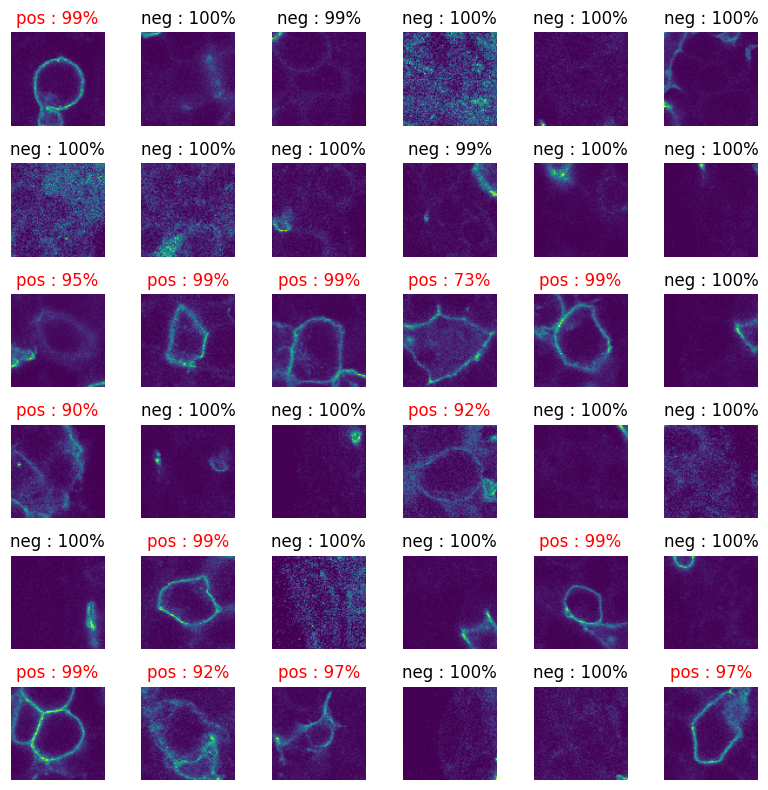

In [15]:
FIG_PATH =  PATH_CD45_data
classes = ['negative', 'positive']

N = 6
img_list = random.sample(sorted(os.listdir(FIG_PATH)), N**2)

fig, ax = plt.subplots(N,N, figsize = (8,8))

for i in range(N):
    for j in range(N):
    
        img = Image.open(os.path.join(FIG_PATH, img_list[i*N+j]))
                
        img_t = prod_transform(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)

        outputs = model_load(batch_t)
        percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        _, preds = torch.max(outputs, 1)

        preds = preds.cpu().detach().numpy()
        percentage = percentage.cpu().detach().numpy()
        
        ax[i,j].imshow(img)
        if classes[preds[0]] == 'positive':
            ax[i,j].set_title(classes[preds[0]][0:3] + ' : ' + str(int(percentage[preds[0]])) + '%', color = 'r')
        else:
            ax[i,j].set_title(classes[preds[0]][0:3] + ' : ' + str(int(percentage[preds[0]])) + '%', color = 'k')
        ax[i,j].axis('off')
        
plt.tight_layout()